# Time Series Prediction of LSTM with keras

- 参考URL
    - https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

## Import library

In [1]:
import numpy as np
import pandas as pd

from datetime import datetime

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%config InlineBackend.figure_formats = {'png', 'retina'}

from sklearn import preprocessing

import keras

Using TensorFlow backend.


## Load Data

In [2]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pollution.csv"

def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')

date_cols = [['year', 'month', 'day', 'hour']]
raw_df = pd.read_csv(url, parse_dates=date_cols, index_col=0, date_parser=parse)
raw_df.drop('No', axis=1, inplace=True)
raw_df.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
raw_df.index.name = 'date'
raw_df['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
raw_df = raw_df[24:]

In [3]:
print(raw_df.shape)
raw_df.head()

(43800, 8)


,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


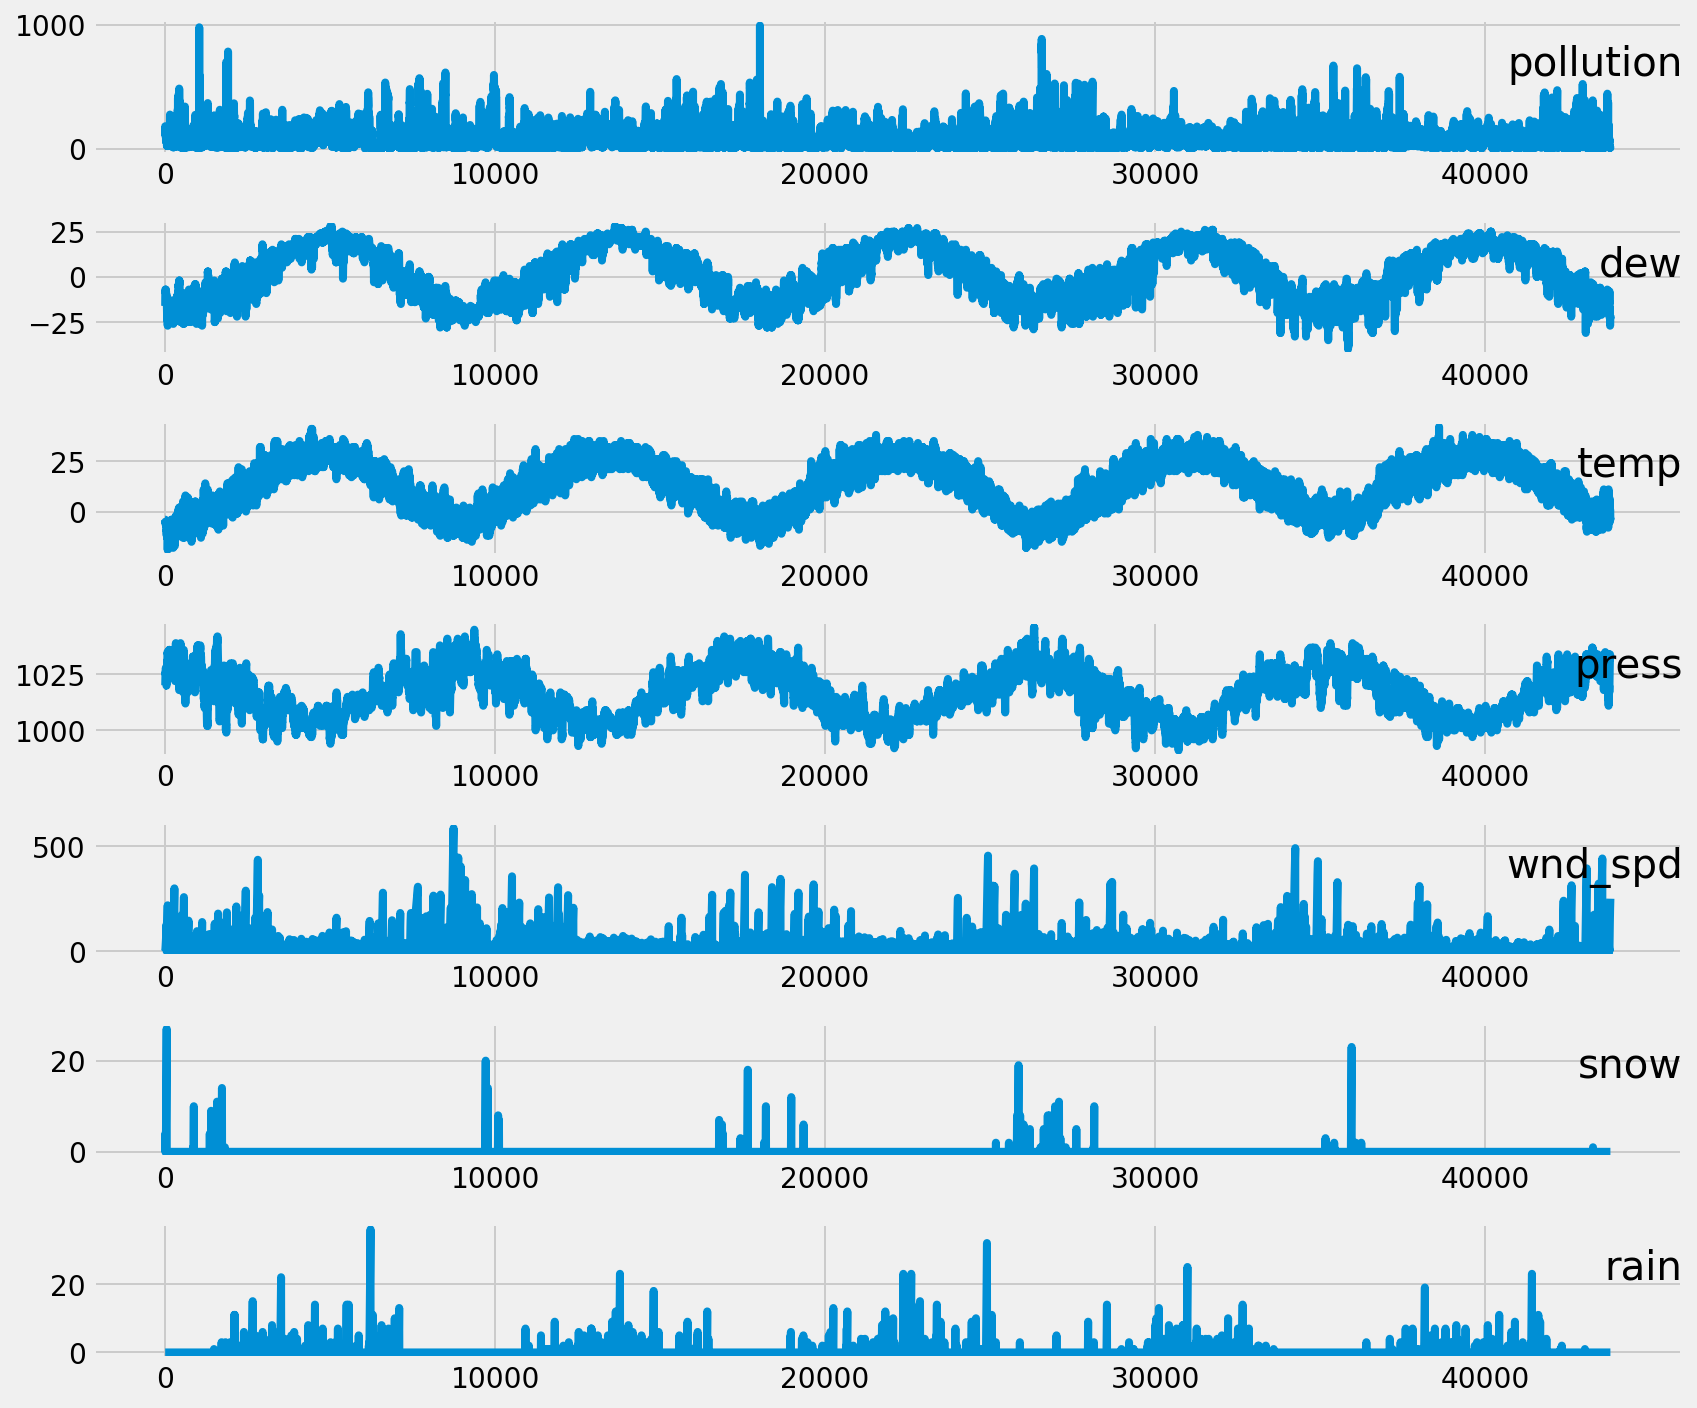

In [4]:
values = raw_df.values
# Only numeric cols
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
plt.figure(figsize=(12, 10))
for i, group in enumerate(groups):
    plt.subplot(len(groups), 1, i+1)
    plt.plot(values[:, group])
    plt.title(raw_df.columns[group], y=0.5, loc='right')
plt.tight_layout()
plt.show()

## Data Preparation

In [6]:
# convert series to supervised learning
def series_to_supervised(df, target, n_lag=1, dropnan=True):
    data = []
    col_names = []
    
    for lag in range(n_lag, 0, -1):
        lag_df = df.shift(-lag).add_suffix(f'_lag-{lag}')
        data.append(lag_df)
        col_names.extend(lag_df.columns.tolist())

    dst_df = pd.DataFrame(np.concatenate(data, axis=1), columns=col_names)
    dst_df = pd.concat([dst_df, df.reset_index(drop=True)], axis=1)
    if dropnan:
        dst_df.dropna(inplace=True)
    return dst_df

In [7]:
# MEMO: Predict All Feature
# convert series to supervised learning
def series_to_supervised(df, target, n_lag=1, dropnan=True):
    data = []
    col_names = []
    
    for lag in range(n_lag, 0, -1):
        lag_df = df.shift(-lag).add_suffix(f'_lag-{lag}')
        data.append(lag_df)
        col_names.extend(lag_df.columns.tolist())

    dst_df = pd.DataFrame(np.concatenate(data, axis=1), columns=col_names)
    dst_df = pd.concat([dst_df, df.reset_index(drop=True)], axis=1)
    if dropnan:
        dst_df.dropna(inplace=True)
    return dst_df

In [8]:
df = raw_df.copy()
# LabelEncode
categories = ['wnd_dir']
for c in categories:
    encoder = preprocessing.LabelEncoder()
    df[c] = encoder.fit_transform(df[c])
df = df.astype('float32')
# # Transform
df = series_to_supervised(df, target='pollution')
# # Scaler
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
scaler.fit(df.values)
df = pd.DataFrame(scaler.transform(df.values), columns=df.columns)

print(df.shape)
df.head()

(43799, 16)


,pollution_lag-1,dew_lag-1,temp_lag-1,press_lag-1,wnd_dir_lag-1,wnd_spd_lag-1,snow_lag-1,rain_lag-1,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0
1,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0
2,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0
3,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0
4,0.109658,0.485294,0.213115,0.563637,0.666667,0.011433,0.111111,0.0,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0


## Define and Fit Model

In [25]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [23]:
# split into train and test sets
# Split fist 1 years for train data
target='pollution'
n_feautre = raw_df.shape[1]
n_train_hours = 2 * 365 * 24
train = df.iloc[:n_train_hours, :]
test = df.iloc[n_train_hours:, :]

# split into input and outputs
train_X, train_y = train.iloc[:, :-n_feautre].values, train.iloc[:, -n_feautre:].values
test_X, test_y = test.iloc[:, :-n_feautre].values, test.iloc[:, -n_feautre:].values

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print('Train', train_X.shape, train_y.shape)
print('Test', test_X.shape, test_y.shape)

Train (17520, 1, 8) (17520, 8)
Test (26279, 1, 8) (26279, 8)


In [26]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(n_feautre))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(
    train_X, train_y, 
    epochs=50, 
    batch_size=72, 
    validation_data=(test_X, test_y), verbose=1, shuffle=False
)

Train on 17520 samples, validate on 26279 samples
Epoch 1/50
17520/17520 [==============================] - 1s 61us/step - loss: 0.1221 - val_loss: 0.0983
Epoch 2/50
17520/17520 [==============================] - 1s 37us/step - loss: 0.0732 - val_loss: 0.0903
Epoch 3/50
17520/17520 [==============================] - 1s 39us/step - loss: 0.0559 - val_loss: 0.0901
Epoch 4/50
17520/17520 [==============================] - 1s 37us/step - loss: 0.0486 - val_loss: 0.0831
Epoch 5/50
17520/17520 [==============================] - 1s 37us/step - loss: 0.0442 - val_loss: 0.0760
Epoch 6/50
17520/17520 [==============================] - 1s 37us/step - loss: 0.0405 - val_loss: 0.0684
Epoch 7/50
17520/17520 [==============================] - 1s 41us/step - loss: 0.0369 - val_loss: 0.0589
Epoch 8/50
17520/17520 [==============================] - 1s 43us/step - loss: 0.0340 - val_loss: 0.0515
Epoch 9/50
17520/17520 [==============================] - 1s 41us/step - loss: 0.0323 - val_loss: 0.0488
Epoch

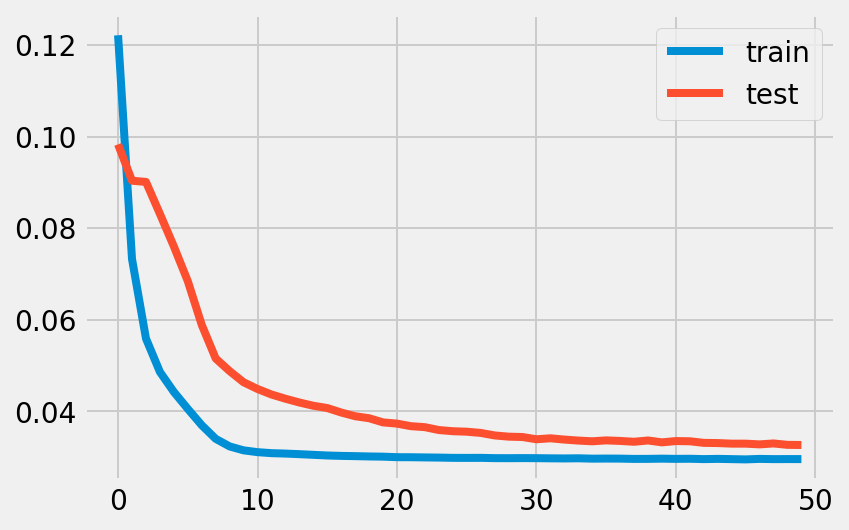

In [27]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Evaluate Model

Train RMSE: 28.919


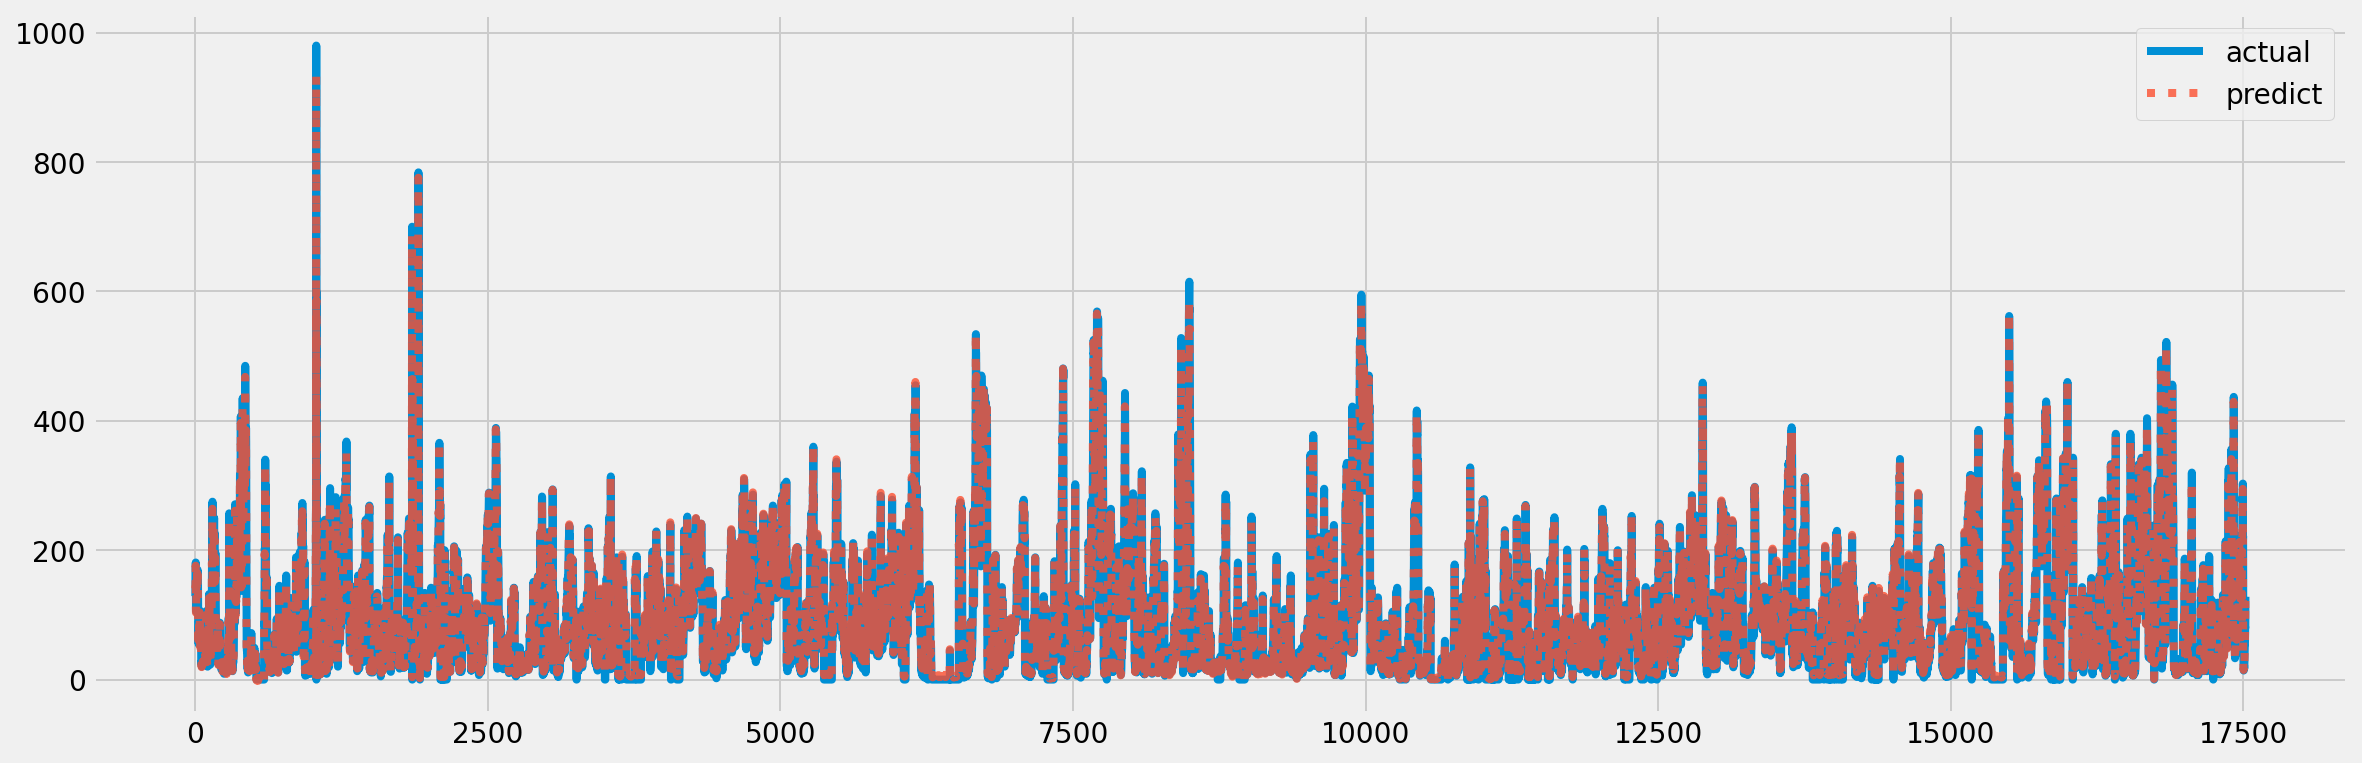

Test RMSE: 26.377


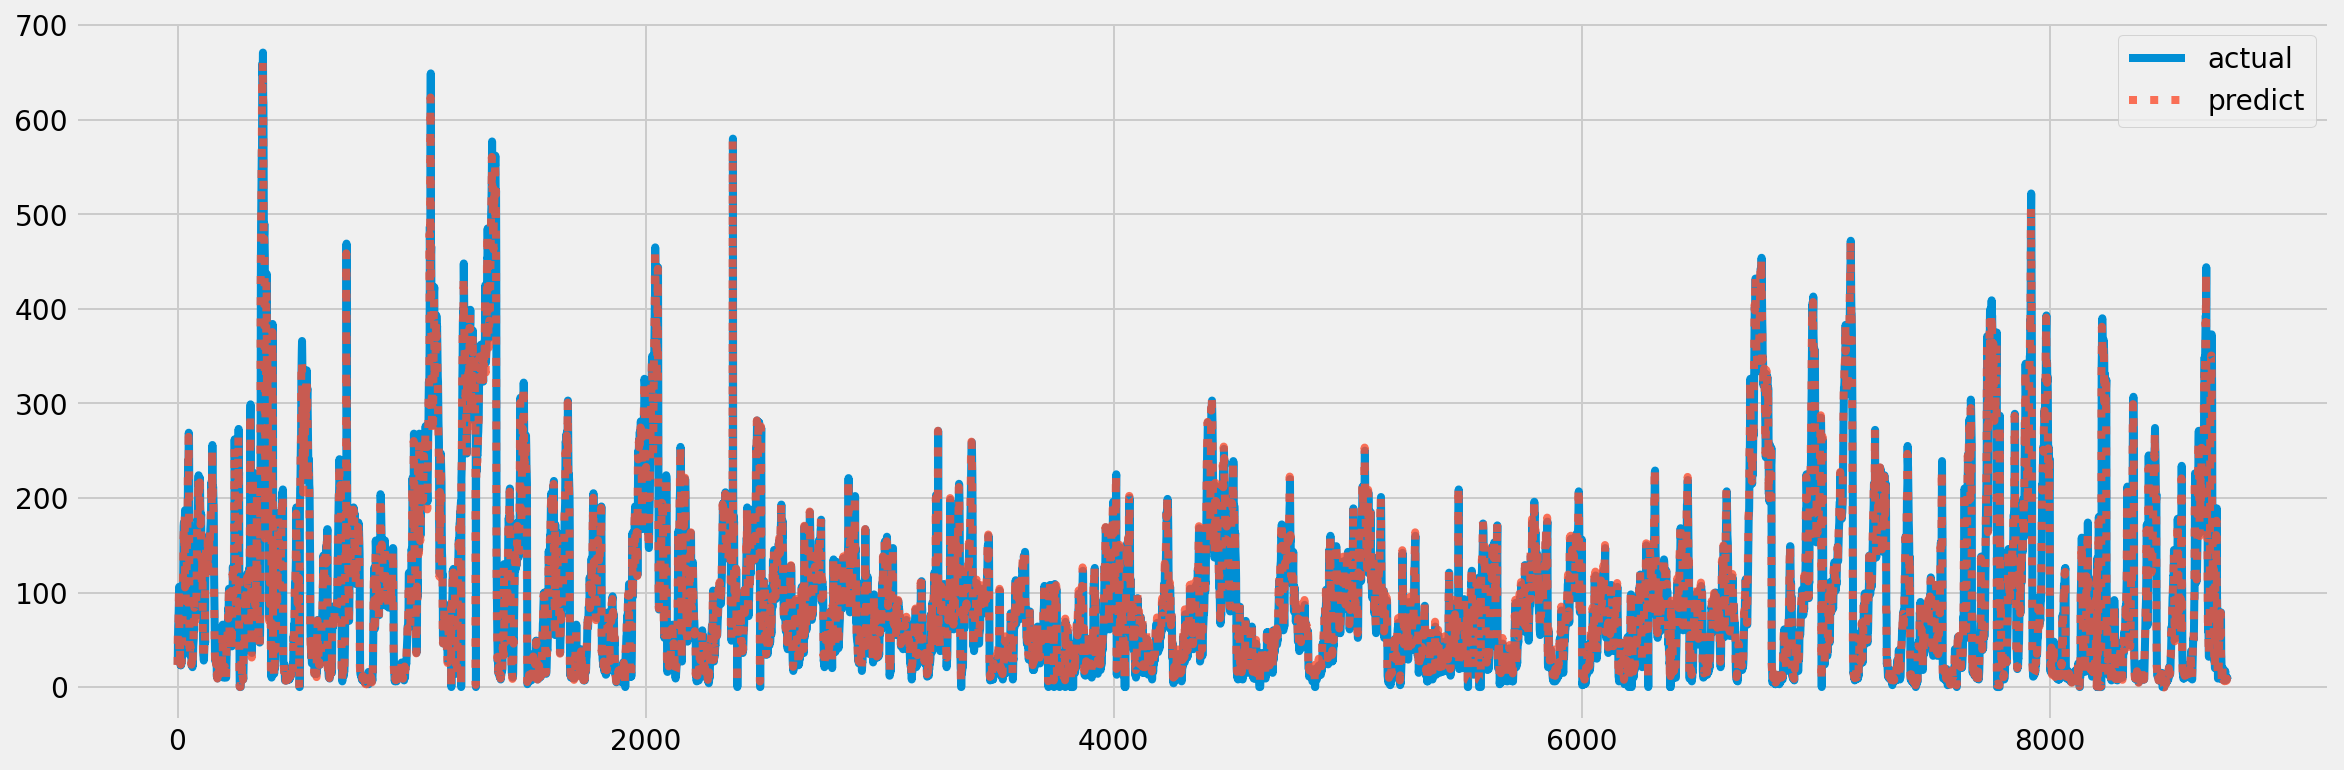

In [42]:
def inverse_scaler(scaler, X, y):
    data = np.concatenate((y, X), axis=1)
    inv_data = scaler.inverse_transform(data)
    return inv_data

inv_actual = inv_actual = inverse_scaler(scaler, train_X[:, 0], train_y)[:, 0]
pred = model.predict(train_X)
inv_pred = inverse_scaler(scaler, train_X[:, 0], pred)[:, 0]

rmse = np.sqrt(mean_squared_error(inv_actual, inv_pred))
print('Train RMSE: %.3f' % rmse)
plt.figure(figsize=(18, 6))
plt.plot(inv_actual, label='actual')
plt.plot(inv_pred, label='predict', linestyle=':', markersize=1, alpha=0.8)
plt.legend()
plt.show()

pred = model.predict(test_X)
inv_pred = inverse_scaler(scaler, test_X[:, 0], pred)[:, 0]
inv_actual = inv_actual = inverse_scaler(scaler, test_X[:, 0], test_y)[:, 0]

rmse = np.sqrt(mean_squared_error(inv_actual, inv_pred))
print('Test RMSE: %.3f' % rmse)
plt.figure(figsize=(18, 6))
plt.plot(inv_actual[-365*24:], label='actual')
plt.plot(inv_pred[-365*24:], label='predict', linestyle=':', markersize=1, alpha=0.8)
plt.legend()
plt.show()

## Train On Multiple Lag Timesteps Example

- ここまでは8種類の変数の１時間前の値を特徴量としていた。
- さらに、1~3時間前の値を特徴量として予測を行ってみる。

In [216]:
n_hours = 3
df = raw_df.copy()
# LabelEncode
categories = ['wnd_dir']
for c in categories:
    encoder = preprocessing.LabelEncoder()
    df[c] = encoder.fit_transform(df[c])
df = df.astype('float32')
# # Transform
df = series_to_supervised(df, target='pollution', n_lag=n_hours)
# Scaler
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
scaler.fit(df.values)
df = pd.DataFrame(scaler.transform(df.values), columns=df.columns)

print(df.shape)
df.head()

(43797, 25)


,pollution_lag-3,dew_lag-3,temp_lag-3,press_lag-3,wnd_dir_lag-3,wnd_spd_lag-3,snow_lag-3,rain_lag-3,pollution_lag-2,dew_lag-2,...,rain_lag-2,pollution_lag-1,dew_lag-1,temp_lag-1,press_lag-1,wnd_dir_lag-1,wnd_spd_lag-1,snow_lag-1,rain_lag-1,pollution
0,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.159960,0.426471,...,0.0,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.129779
1,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.182093,0.485294,...,0.0,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.148893
2,0.109658,0.485294,0.213115,0.563637,0.666667,0.011433,0.111111,0.0,0.138833,0.485294,...,0.0,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.159960
3,0.105634,0.485294,0.213115,0.581818,0.666667,0.014492,0.148148,0.0,0.109658,0.485294,...,0.0,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.182093
4,0.124748,0.485294,0.229508,0.600000,0.666667,0.017551,0.000000,0.0,0.105634,0.485294,...,0.0,0.109658,0.485294,0.213115,0.563637,0.666667,0.011433,0.111111,0.0,0.138833


In [221]:
# split into train and test sets
# Split fist 1 years for train data
target='pollution'
n_train_hours = 1 * 365 * 24
train = df.iloc[:n_train_hours, :]
test = df.iloc[n_train_hours:, :]

# split into input and outputs
train_X, train_y = train.drop(target, axis=1).values, train[target].values
test_X, test_y = test.drop(target, axis=1).values, test[target].values

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print('Train', train_X.shape, train_y.shape)
print('Test', test_X.shape, test_y.shape)

Train (8760, 1, 24) (8760,)
Test (35037, 1, 24) (35037,)


In [222]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(
    train_X, train_y, 
    epochs=50, 
    batch_size=72, 
    validation_data=(test_X, test_y), verbose=1, shuffle=False
)

Train on 8760 samples, validate on 35037 samples
Epoch 1/50
8760/8760 [==============================] - 1s 124us/step - loss: 0.0462 - val_loss: 0.0458
Epoch 2/50
8760/8760 [==============================] - 1s 87us/step - loss: 0.0234 - val_loss: 0.0289
Epoch 3/50
8760/8760 [==============================] - 1s 69us/step - loss: 0.0203 - val_loss: 0.0254
Epoch 4/50
8760/8760 [==============================] - 1s 94us/step - loss: 0.0195 - val_loss: 0.0228
Epoch 5/50
8760/8760 [==============================] - 1s 74us/step - loss: 0.0189 - val_loss: 0.0223
Epoch 6/50
8760/8760 [==============================] - 1s 69us/step - loss: 0.0180 - val_loss: 0.0254
Epoch 7/50
8760/8760 [==============================] - 1s 76us/step - loss: 0.0178 - val_loss: 0.0250
Epoch 8/50
8760/8760 [==============================] - 1s 77us/step - loss: 0.0173 - val_loss: 0.0265
Epoch 9/50
8760/8760 [==============================] - 1s 77us/step - loss: 0.0169 - val_loss: 0.0280
Epoch 10/50
8760/8760 [

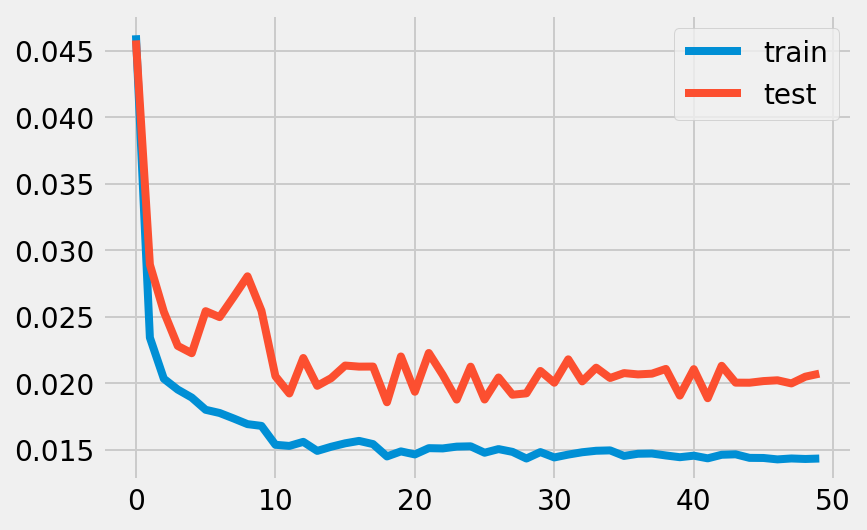

In [223]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Train RMSE: 36.169


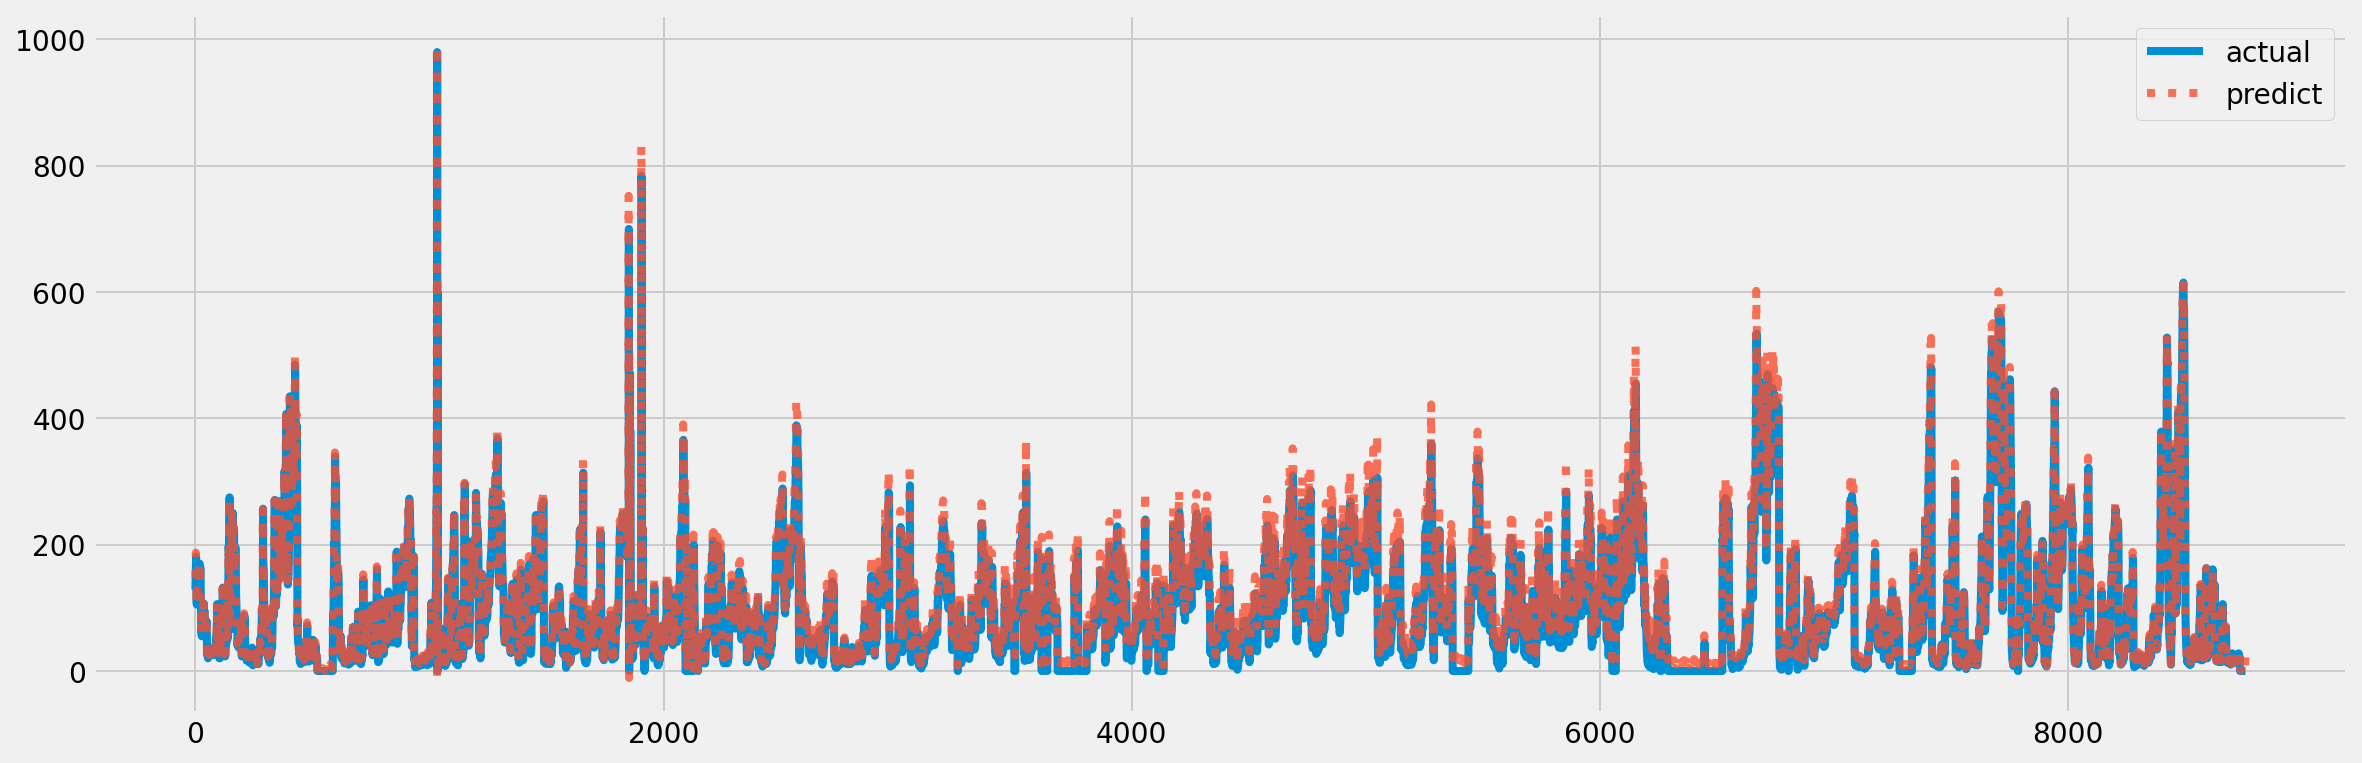

Test RMSE: 31.374


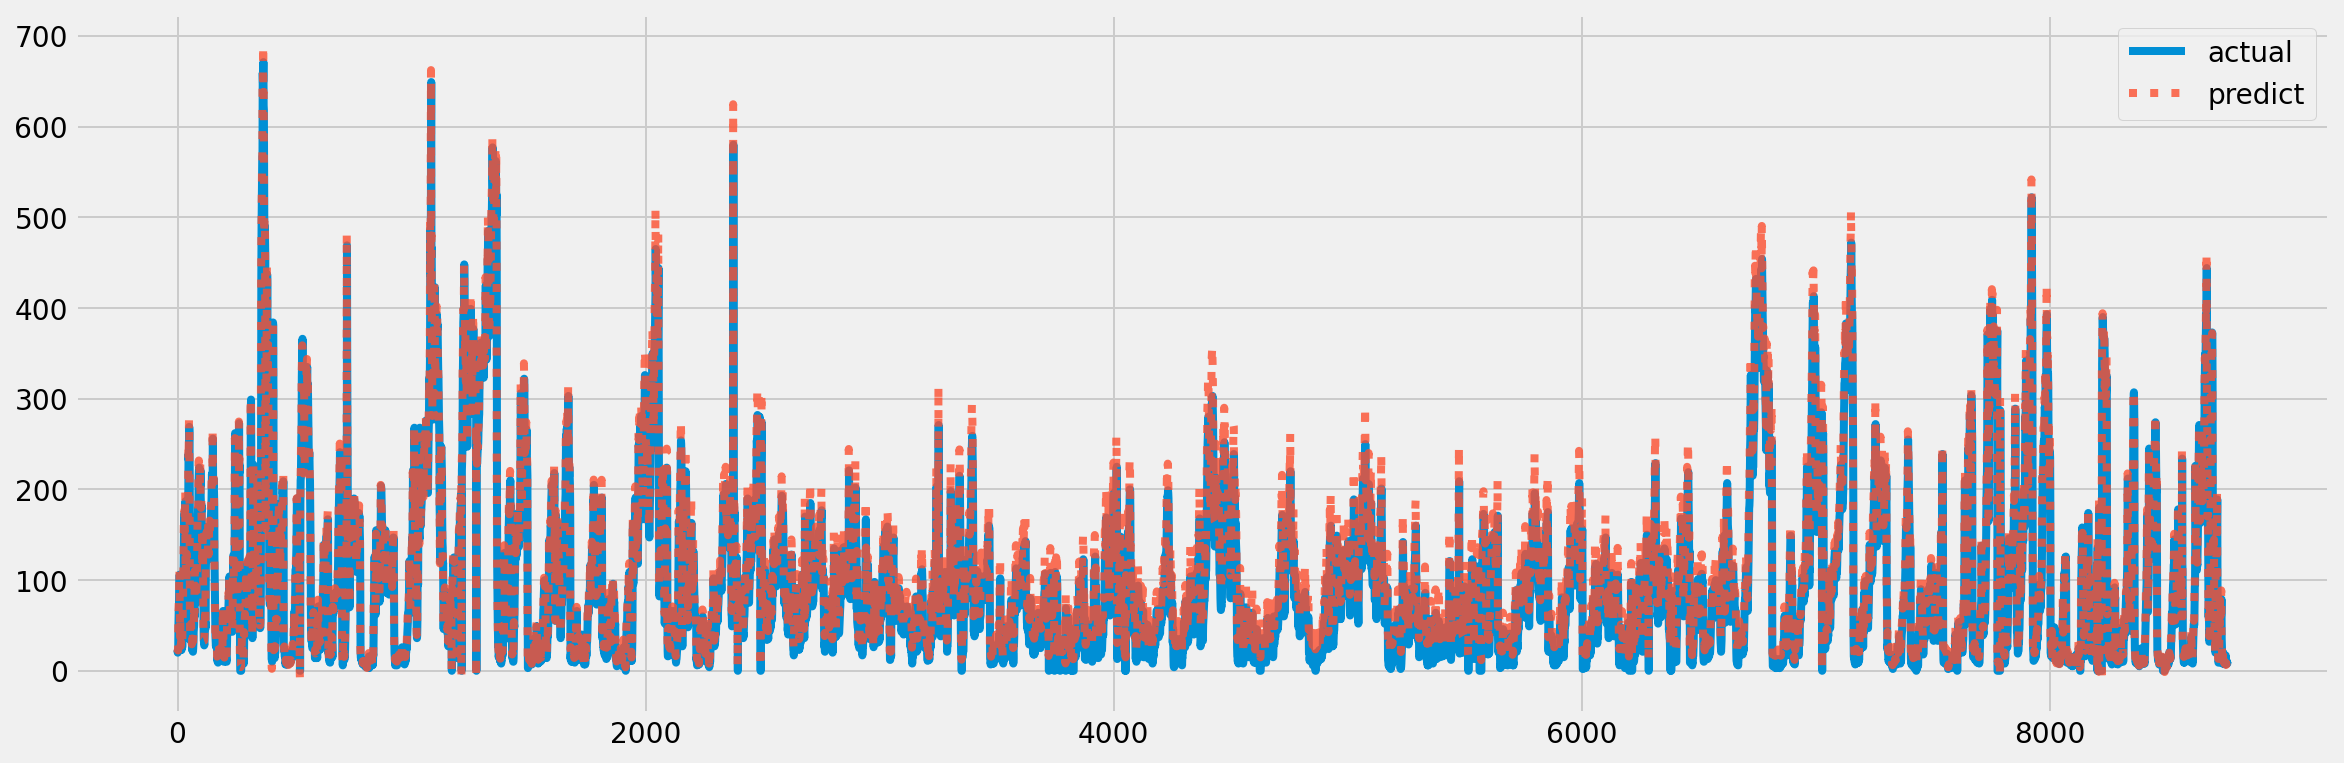

In [225]:
def inverse_scaler(scaler, X, y):
    data = np.concatenate((y, X), axis=1)
    inv_data = scaler.inverse_transform(data)
    return inv_data

inv_actual = inv_actual = inverse_scaler(scaler, train_X[:, 0], train_y.reshape(-1, 1))[:, 0]
pred = model.predict(train_X)
inv_pred = inverse_scaler(scaler, train_X[:, 0], pred)[:, 0]

rmse = np.sqrt(mean_squared_error(inv_actual, inv_pred))
print('Train RMSE: %.3f' % rmse)
plt.figure(figsize=(18, 6))
plt.plot(inv_actual, label='actual')
plt.plot(inv_pred, label='predict', linestyle=':', markersize=1, alpha=0.8)
plt.legend()
plt.show()

pred = model.predict(test_X)
inv_pred = inverse_scaler(scaler, test_X[:, 0], pred)[:, 0]
inv_actual = inv_actual = inverse_scaler(scaler, test_X[:, 0], test_y.reshape(-1, 1))[:, 0]

rmse = np.sqrt(mean_squared_error(inv_actual, inv_pred))
print('Test RMSE: %.3f' % rmse)
plt.figure(figsize=(18, 6))
plt.plot(inv_actual[-365*24:], label='actual')
plt.plot(inv_pred[-365*24:], label='predict', linestyle=':', markersize=1, alpha=0.8)
plt.legend()
plt.show()